In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Malgun Gothic'

import pandas as pd
df = pd.read_parquet(
    'data.parquet',
    engine='pyarrow'         # 저장 시 사용한 엔진과 동일하게 지정
)
test_loaded = pd.read_parquet(
    'test.parquet',
    engine='pyarrow'         # 저장 시 사용한 엔진과 동일하게 지정
)

## 최종 모델 : xgboost + 전체 데이터 학습

In [3]:
# feature / target 정의
ordered_cols = ['Direction', 'time_period']
cat_cols     = [
                'station_number'
                , 'address'
               ] + ordered_cols
num_cols = [
    'HM','RN_DAY','RN_HR1',
    'WD','WS'
    ,'STN'
    ,'sin_dom','cos_dom','sin_dow','cos_dow','sin_hod','cos_hod'
    ,'sin_wom','cos_wom','sin_woy','cos_woy','sin_doy','cos_doy'
    ,'day','day_of_year','hour'
    ,'is_day_before_holiday','is_day_after_holiday','is_holiday','is_weekend'
    ,'month','transfer','week_of_month','week_of_year','weekday','year'
    ,'신설역', '신규관측소'
]
feature_cols = num_cols + ordered_cols + cat_cols
target_col   = 'Congestion'

results = []
final_results = []
print('완료')

완료


In [4]:
import os
import time
import gc
import numpy as np
import pandas as pd
import joblib
import random
from tqdm import tqdm
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# RMSE·R2 평가함수 (train 성능 확인용)
def evaluate_model(name, model, line, X_train, y_train):
    t0 = time.time()
    y_pred = model.predict(X_train)
    elapsed = time.time() - t0
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    r2 = r2_score(y_train, y_pred)
    return {'Model': name, 'Line': line, 'Time(s)': elapsed, 'RMSE': rmse, 'R2': r2}

results = []
final_results = []

for line in df['Line'].unique():
    print(f"\n📘 [Line {line}] Training model...")

    df_line   = df[df['Line'] == line].copy()
    test_line = test_loaded[test_loaded['Line'] == line].copy()

    # 카테고리형 처리
    for col in ['STN', 'address']:
        df_line[col]   = df_line[col].astype('category')
        test_line[col] = test_line[col].astype('category')

    df_line = df_line.sort_values('TM')

    # feature / target / test 준비
    X       = df_line[feature_cols]
    y       = df_line[target_col].astype(int)
    X_test  = test_line[feature_cols]



    # one-hot encoding
    X_enc      = pd.get_dummies(X,       columns=cat_cols)
    X_enc      = X_enc.loc[:, ~X_enc.columns.duplicated()]
    # 1) X_test_enc 생성
    X_test_enc = pd.get_dummies(X_test, columns=cat_cols)
    
    # 2) 중복 컬럼 제거 (테스트용에도 반드시!)
    X_test_enc = X_test_enc.loc[:, ~X_test_enc.columns.duplicated()]
    
    # 3) X_enc 기준으로 컬럼 맞추기
    X_test_enc = X_test_enc.reindex(columns=X_enc.columns, fill_value=0)


    # scaling
    mm             = MinMaxScaler()
    X_scaled       = mm.fit_transform(X_enc).astype(np.float32)
    X_test_scaled  = mm.transform(X_test_enc).astype(np.float32)

    # 모델 정의 (eval_set 제거)
    model = XGBRegressor(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=12,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0.3,
        reg_lambda=0.8,
        min_child_weight=3,
        gamma=0,
        tree_method='hist',
        verbosity=0,
        random_state=42
    )

    # 전체 train으로 학습
    model.fit(X_scaled, y)

    # train 성능 확인
    res = evaluate_model('XGB', model, line, X_scaled, y)
    results.append(res)
    print('Train Result:', res)

    # test 예측
    y_pred = np.round(model.predict(X_test_scaled)).astype(int)
    y_pred = np.clip(y_pred, 0, None)

    temp = test_line[['hour', 'Line', 'station_number']].copy()
    temp['Predicted_Congestion'] = y_pred
    final_results.append(temp)

    # 모델 저장
    os.makedirs('./models', exist_ok=True)
    joblib.dump(model, f"./models/xgb_line{line}.pkl", compress=3)

    # 메모리 해제
    del df_line, test_line, X, y, X_test
    del X_enc, X_test_enc, X_scaled, X_test_scaled, model, y_pred, temp
    gc.collect()

# 결과 합치기 및 저장
final_df = pd.concat(final_results)
output_df = final_df[['Predicted_Congestion']].rename(columns={'Predicted_Congestion': 'Congestion'})
os.makedirs('./test', exist_ok=True)
output_df.to_csv('./test/250206-all.csv', index=False, encoding='utf-8')

results_df = pd.DataFrame(results)
print("\n 성능요약:")
print(results_df)


📘 [Line 1] Training model...
Train Result: {'Model': 'XGB', 'Line': 1, 'Time(s)': 129.1246075630188, 'RMSE': 0.9446972097128356, 'R2': 0.9973877201833138}

📘 [Line 2] Training model...
Train Result: {'Model': 'XGB', 'Line': 2, 'Time(s)': 89.25805234909058, 'RMSE': 0.9029616379356997, 'R2': 0.9980333770607768}

📘 [Line 3] Training model...
Train Result: {'Model': 'XGB', 'Line': 3, 'Time(s)': 85.86855292320251, 'RMSE': 0.7492884423914947, 'R2': 0.9983961969286431}

📘 [Line 4] Training model...
Train Result: {'Model': 'XGB', 'Line': 4, 'Time(s)': 92.0058023929596, 'RMSE': 0.8868580917380746, 'R2': 0.9979805585643077}

📘 [Line 5] Training model...
Train Result: {'Model': 'XGB', 'Line': 5, 'Time(s)': 99.07352137565613, 'RMSE': 0.838972443659636, 'R2': 0.997770559776423}

📘 [Line 6] Training model...
Train Result: {'Model': 'XGB', 'Line': 6, 'Time(s)': 81.70668697357178, 'RMSE': 0.6367142837705477, 'R2': 0.9979249177215723}

📘 [Line 7] Training model...
Train Result: {'Model': 'XGB', 'Line'

In [5]:
gap = pd.read_csv('./test/250206-all.csv') # 내 데터터
gap.shape

import os
제출 = pd.read_csv('minjeong.csv') # 민정언니 데이터

import numpy as np

# 마스크 생성
from sklearn.metrics import root_mean_squared_error
rmse = np.sqrt(mean_squared_error(
    제출['Congestion'],
    gap['Congestion']    # squared=False 하면 RMSE 를 직접 계산해 줌
))

print(f"RMSE: {rmse:.4f}")

RMSE: 3.8042


In [ ]:
# ───────────────────────────────────────────────────────────────
# 0) 라이브러리
# ───────────────────────────────────────────────────────────────
import os, gc, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap

# ───────────────────────────────────────────────────────────────
# 1) 피처 정의
# ───────────────────────────────────────────────────────────────
ordered_cols = ['Direction', 'time_period']
cat_cols     = ['station_number', 'address'] + ordered_cols
num_cols     = [
    'HM','RN_DAY','RN_HR1','TA','WD','WS','STN',
    'sin_dom','cos_dom','sin_dow','cos_dow','sin_hod','cos_hod',
    'sin_wom','cos_wom','sin_woy','cos_woy','sin_doy','cos_doy',
    'day','day_of_year','hour',
    'is_day_before_holiday','is_day_after_holiday',
    'is_holiday','is_weekend','month','transfer',
    'week_of_month','week_of_year','weekday','year',
    '신설역','신규관측소'
]
feature_cols = num_cols + ordered_cols + cat_cols
target_col   = 'Congestion'

# ───────────────────────────────────────────────────────────────
# 2) 전역 컨테이너
# ───────────────────────────────────────────────────────────────
scalers, cols_map, models = {}, {}, {}
train_log = []

# ───────────────────────────────────────────────────────────────
# 3) 8호선 모델 학습
# ───────────────────────────────────────────────────────────────
for line in tqdm([8], desc="Training Line 8"):
    df_line = df[df['Line'] == line].copy()
    for c in cat_cols:
        df_line[c] = df_line[c].astype('category')

    X = df_line[feature_cols]
    y = df_line[target_col].astype(int)

    # one-hot
    X_enc = pd.get_dummies(X, columns=cat_cols)

    # 스케일
    mm       = MinMaxScaler()
    X_scaled = mm.fit_transform(X_enc).astype(np.float32)

    scalers[line]  = mm
    cols_map[line] = X_enc.columns.tolist()

    # 모델
    model = XGBRegressor(
        n_estimators=2000, learning_rate=0.05, max_depth=12,
        subsample=0.9, colsample_bytree=0.8,
        reg_alpha=0.3, reg_lambda=0.8,
        min_child_weight=3, gamma=0,
        tree_method='hist', verbosity=0, random_state=42
    ).fit(X_scaled, y)
    models[line] = model

    # 학습 성능
    y_tr_pred = model.predict(X_scaled)
    train_log.append({
        'Line': line,
        'RMSE': np.sqrt(mean_squared_error(y, y_tr_pred)),
        'R2'  : r2_score(y, y_tr_pred)
    })

    # 모델 저장
    os.makedirs('./models', exist_ok=True)
    joblib.dump(model, './models/xgb_line8.pkl', compress=3)

    del df_line, X, y, X_enc, X_scaled, y_tr_pred
    gc.collect()

print("\n📄 Train Performance")
print(pd.DataFrame(train_log).to_string(index=False))

# ───────────────────────────────────────────────────────────────
# 4) 헬퍼 함수
# ───────────────────────────────────────────────────────────────
def make_X_val(line_id: int, src_df: pd.DataFrame) -> np.ndarray:
    df_val = src_df[src_df['Line'] == line_id].copy()
    for c in cat_cols:
        df_val[c] = df_val[c].astype('category')
    X_val = pd.get_dummies(df_val[feature_cols], columns=cat_cols)\
               .reindex(columns=cols_map[line_id], fill_value=0)
    return scalers[line_id].transform(X_val).astype(np.float32)

def interpret_line(line_id: int, src_df: pd.DataFrame, sample: int = 800):
    print(f"\n🧐 [Line {line_id}] Explainability")
    X_val_full = make_X_val(line_id, src_df)
    model      = models[line_id]

    # ── 성능
    y_true = src_df[src_df['Line'] == line_id][target_col].astype(int).values
    y_pred = model.predict(X_val_full)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f} | "
          f"R²: {r2_score(y_true, y_pred):.4f}")

    # ── ① SHAP summary
    expl = shap.Explainer(model)
    sample_idx = np.random.default_rng(42).choice(
        X_val_full.shape[0], min(sample, X_val_full.shape[0]), replace=False)
    X_shap = X_val_full[sample_idx]
    shap_vals = expl(X_shap, check_additivity=False)
    shap.summary_plot(
        shap_vals,
        features=pd.DataFrame(X_shap, columns=cols_map[line_id]),
        show=False, plot_size=(7, 5)
    )
    plt.tight_layout(); plt.show()

    # ── ② Permutation Importance
    perm = permutation_importance(model, X_shap, model.predict(X_shap),
                                  n_repeats=15, n_jobs=-1, random_state=42)
    (pd.DataFrame({'feature': cols_map[line_id],
                   'imp': perm.importances_mean})
       .sort_values('imp', ascending=False)
       .head(20)
       .plot.barh(x='feature', y='imp', figsize=(6,6), legend=False))
    plt.title(f'Line {line_id} – Permutation Importance (top 20)')
    plt.gca().invert_yaxis()
    plt.tight_layout(); plt.show()

    # ── ③ XGBoost Gain Importance
    gain_imp = model.get_booster().get_score(importance_type='gain')
    (pd.Series(gain_imp, name='gain')
       .sort_values(ascending=False)
       .head(20)
       .to_frame()
       .plot.barh(figsize=(6,6), legend=False))
    plt.title(f'Line {line_id} – XGB Gain Importance (top 20)')
    plt.gca().invert_yaxis()
    plt.tight_layout(); plt.show()



🧐 [Line 8] Explainability
RMSE: 0.5278 | R²: 0.9994


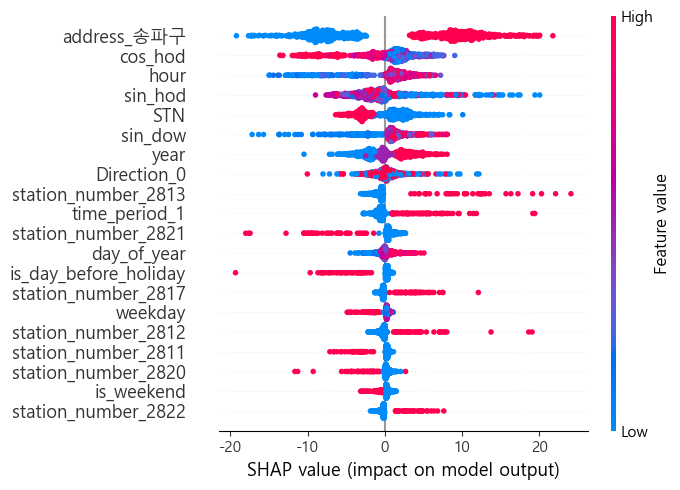

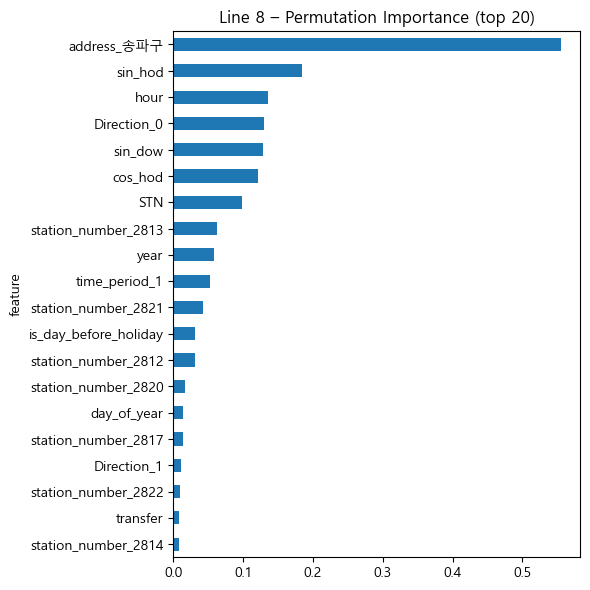

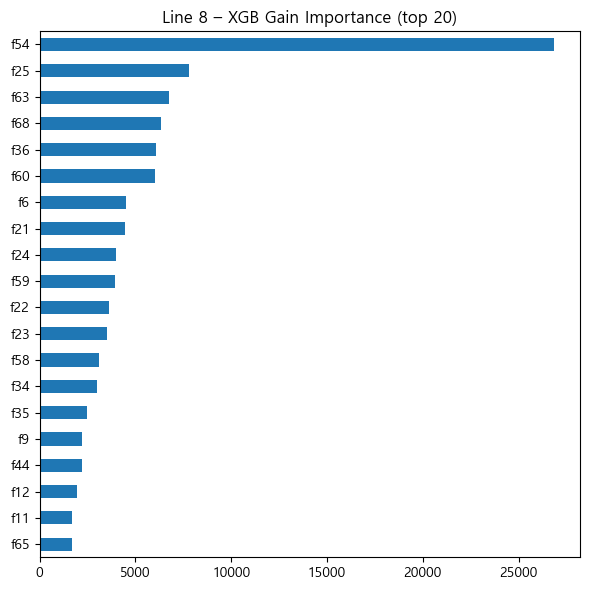

In [16]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False   
interpret_line(8, df, sample=800)